# **Dataset 설명**

 - 선택한 Rohlik 재고 및 날짜에 대한 과거 판매 데이터가 제공됩니다. ID, 판매, 총 주문 및 가격 열은 실제 값을 기밀로 유지하기 위해 변경됩니다. 일부 기능은 예측을 하는 시점에는 알 수 없으므로 테스트에서 사용할 수 없습니다. 작업은 테스트 세트에 대해 unique_id와 date(예: unique_id 1226과 date 2024-06-03에서 id 1226_2024-06-03)로 구성된 주어진 id에 대한 판매 열을 예측하는 것입니다.

파일

 - sales_train.csv - 아래에 설명된 선택된 기능을 갖춘 지정된 날짜 및 재고에 대한 과거 판매 데이터가 포함된 교육 세트
 - sales_test.csv - 전체 테스트 세트
 - inventory.csv - 제품과 같은 재고에 대한 추가 정보(모든 창고의 동일한 제품은 동일한 제품 고유 ID 및 이름을 공유하지만 고유 ID는 다름)
 - solution.csv - 올바른 형식의 전체 제출 파일
 - calendar.csv - 휴일 또는 창고별 이벤트에 대한 데이터가 포함된 달력, 일부 열은 이미 열차 데이터에 있지만 공휴일 또는 일요일로 인해 일부 창고가 닫힐 수 있는 날짜에 대한 추가 행이 이 파일에 있습니다(따라서 열차 세트에 없음)

# **Column 설명**

 # sales_train.csv 및 sales_test.csv
 - unique_id- 재고에 대한 고유 ID
 - date - 날짜
 - warehouse- 창고 이름
 - total_orders- 이 도전의 일부로 테스트 세트로 알려진 선택된 Rohlik 창고에 대한 과거 주문
 - sales- 목표 값, 판매 볼륨(개 또는 kg)은 가용성에 따라 조정됩니다. 1보다 낮은 가용성을 가진 판매는 이미 Rohlik 내부 논리에 의해 전체 잠재 판매로 조정됩니다. 다양한 이유로 주어진 재고에 대한 train과 test에서 날짜가 누락될 수 있습니다. 이 열은 test.csv에서 누락되었는데, 이는 목표 변수이기 때문입니다.
 - sell_price_main- 판매 가격
 - availability- 재고가 고객에게 제공될 수 있었던 하루의 비율. 재고는 항상 제공될 필요는 없습니다. 값 1은 하루 종일 제공되었음을 의미합니다. 이 열은 예측을 하는 시점에는 알 수 없기 때문에 test.csv에 없습니다.
 - type_0_discount, type_1_discount, … - Rohlik은 다양한 유형의 프로모 세일 액션을 실행하고 있으며, 이는 프로모 기간 동안 원래 가격의 백분율을 보여줍니다(( original price- current_price) / original_price). 다양한 유형의 여러 할인을 동시에 실행할 수 있지만, 이러한 유형 중 가장 높은 할인이 항상 세일에 사용됩니다. 음수 할인 값은 할인 없음으로 해석해야 합니다.

 # 인벤토리.csv
 - unique_id - 단일 보관 단위에 대한 인벤토리 ID
 - product_unique_id - 제품 ID, 각 창고의 재고는 동일한 제품 고유 ID를 갖습니다(모든 창고의 동일한 제품은 동일한 제품 ID를 갖지만 고유 ID는 다름)
 - name - 단일 보관 단위에 대한 인벤토리 ID
 - L1_category_name, L2_category_name, … - 내부 카테고리의 이름입니다. 숫자가 높을수록 더 세부적인 정보가 제공됩니다.
 - warehouse - 창고 이름

 # 달력.csv
 - warehouse - 창고 이름
 - date - 날짜
 - holiday_name - 공휴일이 있는 경우 공휴일 이름
 - holiday - 0/1은 휴일이 있음을 나타냅니다.
 - shops_closed - 대부분의 상점 또는 상당수의 상점이 문을 닫는 공휴일
 - winter_school_holidays - 겨울방학
 - school_holidays - 학교 방학

 # 테스트_가중치.csv
 - unique_id - 단일 보관 단위에 대한 인벤토리 ID
 - weight- 최종 메트릭 계산에 사용되는 가중치

# **Rohlik Sales Prediction**
### 1. 데이터 클렌징 및 가공

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

sales_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Rohlik Sales Prediction/sales_train.csv')
print(sales_train_df.shape)
sales_train_df.head(5)

(4007419, 14)


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0


In [3]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   unique_id        int64  
 1   date             object 
 2   warehouse        object 
 3   total_orders     float64
 4   sales            float64
 5   sell_price_main  float64
 6   availability     float64
 7   type_0_discount  float64
 8   type_1_discount  float64
 9   type_2_discount  float64
 10  type_3_discount  float64
 11  type_4_discount  float64
 12  type_5_discount  float64
 13  type_6_discount  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 428.0+ MB


1. 날짜별 평균 판매량 시각화

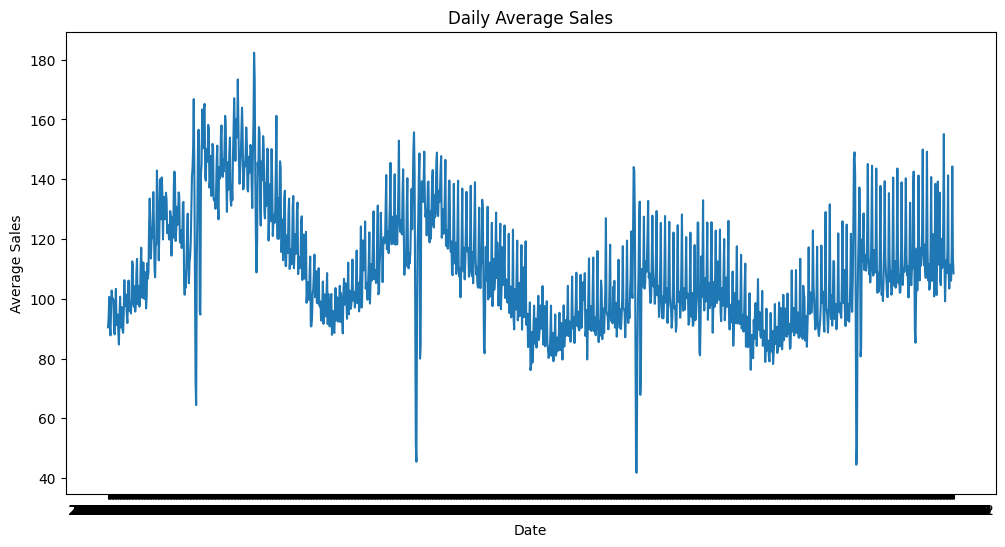

In [4]:
# 날짜별 평균 판매량 계산
daily_sales = sales_train_df.groupby('date')['sales'].mean().reset_index()

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', data=daily_sales)
plt.title('Daily Average Sales')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.show()

2. 창고별 판매량 비교

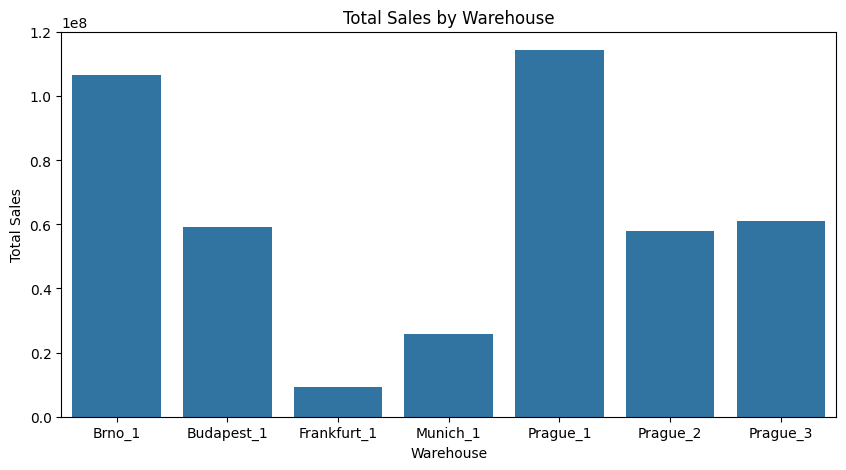

In [5]:
# 창고별 총 판매량 계산
warehouse_sales = sales_train_df.groupby('warehouse')['sales'].sum().reset_index()

# 시각화
plt.figure(figsize=(10, 5))
sns.barplot(x='warehouse', y='sales', data=warehouse_sales)
plt.title('Total Sales by Warehouse')
plt.xlabel('Warehouse')
plt.ylabel('Total Sales')
plt.show()

3. 특정 제품 카테고리별 판매량 차이 분석

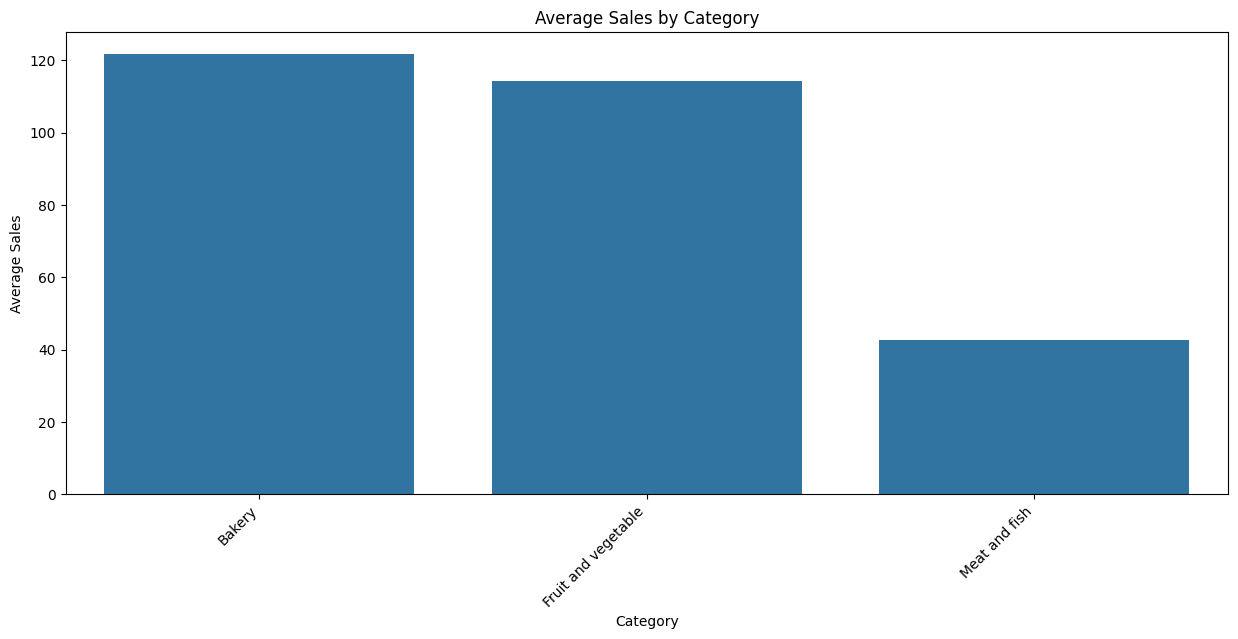

In [6]:
# inventory 데이터 불러오기 (제품 카테고리 정보 포함)
inventory_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Rohlik Sales Prediction/inventory.csv')

# sales_train 데이터와 inventory 데이터 병합
merged_df = pd.merge(sales_train_df, inventory_df[['unique_id', 'L1_category_name_en']], on='unique_id')

# 카테고리별 평균 판매량 계산
category_sales = merged_df.groupby('L1_category_name_en')['sales'].mean().reset_index()

# 시각화
plt.figure(figsize=(15, 6))
sns.barplot(x='L1_category_name_en', y='sales', data=category_sales)
plt.title('Average Sales by Category')
plt.xlabel('Category')
plt.ylabel('Average Sales')
plt.xticks(rotation=45, ha='right')
plt.show()

# **2. 간단한 예측 모델 만들기 (Baseline Model)**
- 과거 평균 판매량을 기반으로 간단한 예측 모델을 생성하고 성능을 평가

1) unique_id별 최근 7일 평균 판매량 계산

2) Linear Regression 모델 학습 및 예측

In [14]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [15]:
# 1. 데이터 준비
# sales_train.csv 파일 로드
sales_train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Rohlik Sales Prediction/sales_train.csv')

# 날짜 데이터 변환
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'])

# 결측치 확인 및 처리 (sales 열)
print(sales_train_df['sales'].isnull().sum()) # 결측치 개수 확인
sales_train_df['sales'] = sales_train_df['sales'].fillna(sales_train_df['sales'].mean()) # 평균값으로 채우기

52


In [16]:
# 2. Feature 엔지니어링
# 최근 7일 평균 판매량 계산
def get_recent_sales(df, unique_id, date, window=7):
    recent_sales = df[(df['unique_id'] == unique_id) & (df['date'] < date)].tail(window)
    avg_sales = recent_sales['sales'].mean() if len(recent_sales) > 0 else 0
    return avg_sales

# 예측 대상 날짜 설정
target_date = sales_train_df['date'].max() + pd.DateOffset(days=1)

In [17]:
# unique_id별 최근 7일 평균 판매량 계산
features = []
for unique_id in sales_train_df['unique_id'].unique():
    avg_sales = get_recent_sales(sales_train_df, unique_id, target_date)
    features.append([unique_id, target_date, avg_sales])

In [18]:
# Feature DataFrame 생성
features_df = pd.DataFrame(features, columns=['unique_id', 'date', 'recent_7days_avg_sales'])

# sales_train_df에서 target_date에 해당하는 sales 데이터만 추출
sales_target = sales_train_df[sales_train_df['date'] == target_date][['unique_id', 'date', 'sales']]

# features_df와 sales_target 병합
features_df = pd.merge(features_df, sales_target, on=['unique_id', 'date'], how='left')

# sales 열에 NaN 값이 있는 경우 0으로 채우기
features_df['sales'] = features_df['sales'].fillna(0)

In [19]:
# 3. 모델링
# 데이터 분할 (train/test)
X = features_df[['recent_7days_avg_sales']]
y = features_df['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 선택 및 학습
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [20]:
# 4. 예측 및 평가
# 예측
y_pred = model.predict(X_test)

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 0.0, MAE: 0.0


In [21]:
# 가중치 데이터 로드
weights_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/Rohlik Sales Prediction/test_weights.csv')

In [23]:
# WMAE 계산 함수 정의: WMAE를 계산하는 함수를 정의
def wmae(y_true, y_pred, weights):
    return np.mean(weights * np.abs(y_true - y_pred)) / np.mean(weights)

In [25]:
# WMAE 계산 및 출력: 테스트 데이터에 대한 WMAE를 계산하고 출력
# features_df (또는 X_test와 관련된 DataFrame)에 weights 정보 merge
merged_df = pd.merge(features_df, weights_df, on='unique_id', how='left')

# X_test에 해당하는 가중치 가져오기
weights = merged_df.loc[X_test.index, 'weight']

# WMAE 계산
wmae_score = wmae(y_test, y_pred, weights)
print(f"WMAE: {wmae_score}")

WMAE: 0.0


In [26]:
# 1. 예측 결과 저장 및 제출 파일 생성
y_pred = model.predict(X_test)

In [27]:
# 예측값 DataFrame 생성: 예측값을 Pandas DataFrame으로 변환하고, Kaggle 제출 양식에 맞춰 unique_id와 date 정보를 포함
predictions_df = pd.DataFrame({'unique_id': X_test.index, 'date': features_df.loc[X_test.index, 'date'], 'sales': y_pred})

In [28]:
# CSV 파일 저장: DataFrame을 CSV 파일로 저장
predictions_df.to_csv('submission.csv', index=False)